# Baselines for SciFact and Citation-Integrity

This notebook shows baselines for claim verification on two datasets (SciFact and Citation-Integrity) using training checkpoints from the MultiVerS project.

- The training steps are described in [the MultiVerS paper](10.48550/arXiv.2112.01640) and in [training.md](../doc/training.md).
- Pre-training in MultiVerS is performed on the Fever, EvidenceInference and PubmedQA datasets with shuffled data (`fever_sci`)
- Fine-tuning is done on the specific target dataset:
    - COVIDFact (`covidfact`)
    - HealthVer (`healthver`)
    - SciFact (`scifact`)

Start by importing the necessary packages including the `eval` package from this repo for reading the data and predictions and calculating metrics:

In [8]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Get the current directory and parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Import eval from the parent directory
import eval

Calculate F1 scores for each combination of checkpoint, dataset, and fold.

In [17]:
# Start with empty array of the right shape
f1_array = np.zeros(shape=(20, 5))
# Start with empty lists for string columns of output DataFrame
ds, fs, cs = [], [], []

# Loop over checkpoints and datasets
datasets = ['scifact', 'scifact', 'citint', 'citint', 'citint']
folds = ['train', 'dev', 'train', 'dev', 'test']
checkpoints = ['fever_sci', 'covidfact', 'healthver', 'scifact']
for icheckpoint in range(len(checkpoints)):
    for idataset in range(len(datasets)):
        # Read the data and predictions
        dataset = datasets[idataset]
        fold = folds[idataset]
        checkpoint = checkpoints[icheckpoint]
        # Append the names to the lists
        ds.append(dataset)
        fs.append(fold)
        cs.append(checkpoint)
        data = eval.read_data(f'../data/{dataset}', fold)
        predictions = eval.read_predictions(f'../predictions/baseline/{checkpoint}_{dataset}_{fold}.jsonl')
        f1_values = eval.calc_f1(data, predictions)
        # The row index where we'll put the results
        idx = len(datasets) * icheckpoint + idataset
        f1_array[idx] = f1_values


Create a DataFrame and print the first five rows.

In [30]:

f1_df = pd.DataFrame(f1_array.round(2), columns = ['SUPPORT', 'REFUTE', 'NEI', 'micro', 'macro'])
names_df = pd.DataFrame({'dataset': ds, 'fold': fs, 'checkpoint': cs})
df = pd.concat([names_df, f1_df], axis = 1)
df.head()

,dataset,fold,checkpoint,SUPPORT,REFUTE,NEI,micro,macro
0,scifact,train,fever_sci,0.73,0.39,0.76,0.69,0.63
1,scifact,dev,fever_sci,0.74,0.36,0.75,0.69,0.62
2,citint,train,fever_sci,0.56,0.02,0.17,0.34,0.25
3,citint,dev,fever_sci,0.58,0.00,0.22,0.36,0.27
4,citint,test,fever_sci,0.55,0.02,0.22,0.35,0.26


These are the F1 scores for predictions made with the `fever_sci` checkpoint.
Let's use the training fold in each dataset to visualize the trends for all checkpoints.

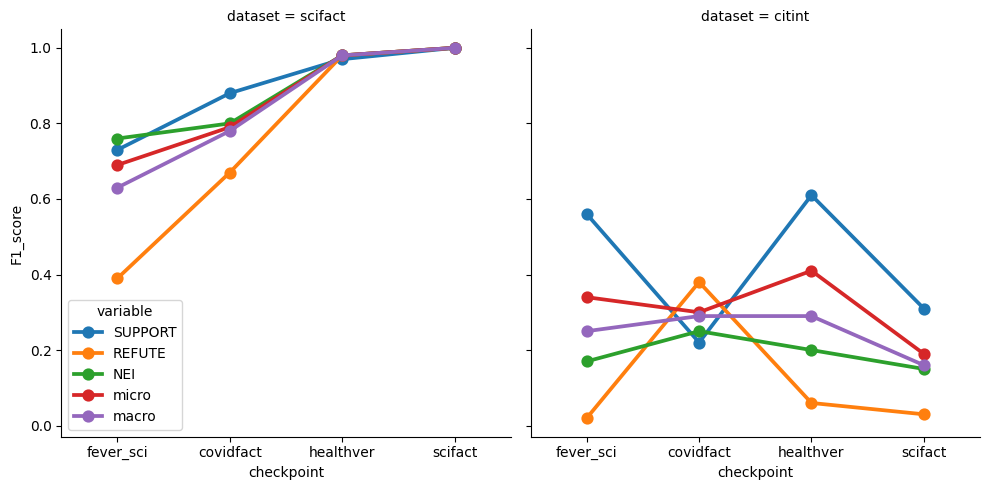

In [34]:
filtered_df = df[df['fold'] == 'train']
df2 = pd.melt(filtered_df, id_vars=['dataset', 'fold', 'checkpoint'], value_name = 'F1_score')
plot_ = sns.catplot(data=df2, col='dataset', x='checkpoint', y='F1_score', hue='variable', kind='point', legend_out=False)

As expected, the best predictions for SciFact come from the `scifact` checkpoint that was fine-tuned on that dataset.

For Citation-Integrity, `healthver` shows the highest micro and macro F1 and good performance for all labels except REFUTE.
On the other hand, `covidfact` produces the highest F1 score for REFUTE, but the lowest score for SUPPORT.
This is likely related to the [high number of COVID-related statements](http://localhost:8888/notebooks/05_Data-Exploration-for-Citation-Integrity.ipynb#Wordcloud) in Citation-Integrity.

**Actions**
- Athough the Citation-Integrity study started training from the `healthver` checkpoint, we should consider using the `covidfact` checkpoint.
- Training on multiple datasets (not only the target) might increase the model accuracy.
- The `scifact` checkpoint from the MultiVerS study achieves 100% F1 scores for the training and validation folds. Can we expect similar performance from fine-tuning on Citation-Integrity?

In [32]:
df[(df['dataset'] == 'scifact') & (df['checkpoint'] == 'scifact')]

,dataset,fold,checkpoint,SUPPORT,REFUTE,NEI,micro,macro
15,scifact,train,scifact,1.0,1.0,1.0,1.0,1.0
16,scifact,dev,scifact,1.0,1.0,1.0,1.0,1.0
